In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('e:/PythonProjects/AlgoGameSim')

from agent import Agent, CulturalEnum
from content import Content
from logic import compute_base_match_df

import matplotlib.pyplot as plt

In [2]:
# Generate 100 random agents
num_agents = 100
agents = []

for i in range(num_agents):
    agent = Agent(
        education=np.random.randint(1, 6),
        economic_status=np.random.uniform(10000, 500000),
        ethics=np.random.uniform(0, 1),
        politics=np.random.randint(-2, 3),
        cultural=np.random.choice(list(CulturalEnum)),
        age=np.random.randint(5, 91),
        sex=np.random.randint(0, 2),
        novelty=np.random.uniform(0, 1),
        conscientiousness=np.random.uniform(0, 1),
        impulsivity=np.random.uniform(0, 1),
        tech_affinity=np.random.uniform(0, 1),
        social_trust=np.random.uniform(0, 1)
    )
    agents.append(agent)

# Create DataFrame from agents
agents_data = [agent.to_dict() for agent in agents]
df_agents = pd.DataFrame(agents_data)

# Create tiered income column (5 tiers mapped to 0..1) based on agents' min/max
num_tiers = 5
min_inc = pd.to_numeric(df_agents['economic_status'], errors='coerce').min()
max_inc = pd.to_numeric(df_agents['economic_status'], errors='coerce').max()

def _map_to_tier(v):
    try:
        val = pd.to_numeric(v, errors='coerce')
    except Exception:
        return np.nan
    if pd.isna(val) or pd.isna(min_inc) or pd.isna(max_inc) or max_inc == min_inc:
        return np.nan
    frac = (val - min_inc) / (max_inc - min_inc)
    frac_clipped = max(0.0, min(1.0, frac))
    tier_idx = int(round(frac_clipped * (num_tiers - 1)))
    return tier_idx / (num_tiers - 1)

df_agents['tiered_income'] = df_agents['economic_status'].apply(_map_to_tier)

# Show result
df_agents.head()

,agent_id,education,economic_status,ethics,politics,cultural,age,sex,novelty,conscientiousness,impulsivity,tech_affinity,social_trust,tiered_income
0,b74b3497-71a7-4143-aee7-c325e38ea19c,1,180000,0.530663,1,eastern,32,0,0.229871,0.544972,0.437600,0.767313,0.114378,0.25
1,f20a7d3d-8a66-4967-983f-23725e707d38,3,245000,0.537378,-1,eastern,86,0,0.777746,0.943435,0.350105,0.457142,0.119331,0.50
2,120dccdb-4700-48b4-8f94-e7d5d182e317,5,450000,0.654667,-2,indigenous,28,1,0.153906,0.455972,0.213840,0.327870,0.647290,1.00
3,b4bf7832-9c15-45b0-8c7b-d4ff971dc17e,3,380000,0.770281,1,eastern,48,1,0.251744,0.823556,0.908993,0.424338,0.719095,0.75
4,54f64627-7660-4a86-98b5-28f1c8f16e34,3,435000,0.730534,1,african,26,1,0.741911,0.803386,0.490505,0.693840,0.311204,0.75


In [3]:
# Create a single Content instance with only selected fields
value_econ = np.random.uniform(10000, 500000)
content = Content(
    economic_status=value_econ,
    ethics = np.random.uniform(0,1),
    novelty=np.random.uniform(0, 1),
    conscientiousness=np.random.uniform(0, 1),
    impulsivity=np.random.uniform(0, 1)
)

# Store in a DataFrame
df_content = pd.DataFrame([content.to_dict()])

# Assign tiered_income to content using the same mapping from df_agents
if 'economic_status' in df_content.columns:
    df_content['tiered_income'] = df_content['economic_status'].apply(_map_to_tier)
else:
    df_content['tiered_income'] = np.nan

df_content

,content_id,education,economic_status,ethics,politics,cultural,age,sex,novelty,conscientiousness,impulsivity,tech_affinity,social_trust,tiered_income
0,7fee4515-1ffb-4875-94fa-f0fa841f62d0,None,440000,0.810501,None,None,None,None,0.980909,0.370419,0.494848,None,None,1.0


In [4]:
# Use the first (and only) row of df_content as the content mapping
content_map = df_content.iloc[0].to_dict()

# Compute base match scores between all agents and this content instance
df_with_scores = compute_base_match_df(df_agents, content_map)

df_with_scores

,agent_id,education,economic_status,ethics,politics,cultural,age,sex,novelty,conscientiousness,...,tech_affinity,social_trust,tiered_income,diff_tiered_income,diff_ethics,diff_politics,diff_age,diff_sex,diff_cultural,base_score
0,b74b3497-71a7-4143-aee7-c325e38ea19c,1,180000,0.530663,1,eastern,32,0,0.229871,0.544972,...,0.767313,0.114378,0.25,0.75,0.279838,NaN,NaN,NaN,NaN,0.485081
1,f20a7d3d-8a66-4967-983f-23725e707d38,3,245000,0.537378,-1,eastern,86,0,0.777746,0.943435,...,0.457142,0.119331,0.50,0.50,0.273123,NaN,NaN,NaN,NaN,0.613439
2,120dccdb-4700-48b4-8f94-e7d5d182e317,5,450000,0.654667,-2,indigenous,28,1,0.153906,0.455972,...,0.327870,0.647290,1.00,0.00,0.155834,NaN,NaN,NaN,NaN,0.922083
3,b4bf7832-9c15-45b0-8c7b-d4ff971dc17e,3,380000,0.770281,1,eastern,48,1,0.251744,0.823556,...,0.424338,0.719095,0.75,0.25,0.040220,NaN,NaN,NaN,NaN,0.854890
4,54f64627-7660-4a86-98b5-28f1c8f16e34,3,435000,0.730534,1,african,26,1,0.741911,0.803386,...,0.693840,0.311204,0.75,0.25,0.079967,NaN,NaN,NaN,NaN,0.835017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,b1d922ce-a9cd-4151-8bc2-86306b00fd31,2,235000,0.947030,2,multicultural,40,0,0.055081,0.060080,...,0.069364,0.198478,0.50,0.50,0.136530,NaN,NaN,NaN,NaN,0.681735
96,1065aa85-dc39-4233-9416-d2b88f64db7f,3,145000,0.817383,1,african,5,1,0.186339,0.062095,...,0.986533,0.948371,0.25,0.75,0.006882,NaN,NaN,NaN,NaN,0.621559
97,f45d832b-151b-4f39-bff1-1d38a3868758,3,455000,0.227936,0,african,10,1,0.261413,0.370391,...,0.006412,0.694770,1.00,0.00,0.582565,NaN,NaN,NaN,NaN,0.708717
98,8faa256c-c42e-47de-b516-be92466a7ada,4,275000,0.428779,0,african,84,0,0.305422,0.916632,...,0.803929,0.288353,0.50,0.50,0.381722,NaN,NaN,NaN,NaN,0.559139


C:\Users\Tim\AppData\Local\Temp\ipykernel_30656\1101657204.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels, rotation=0)


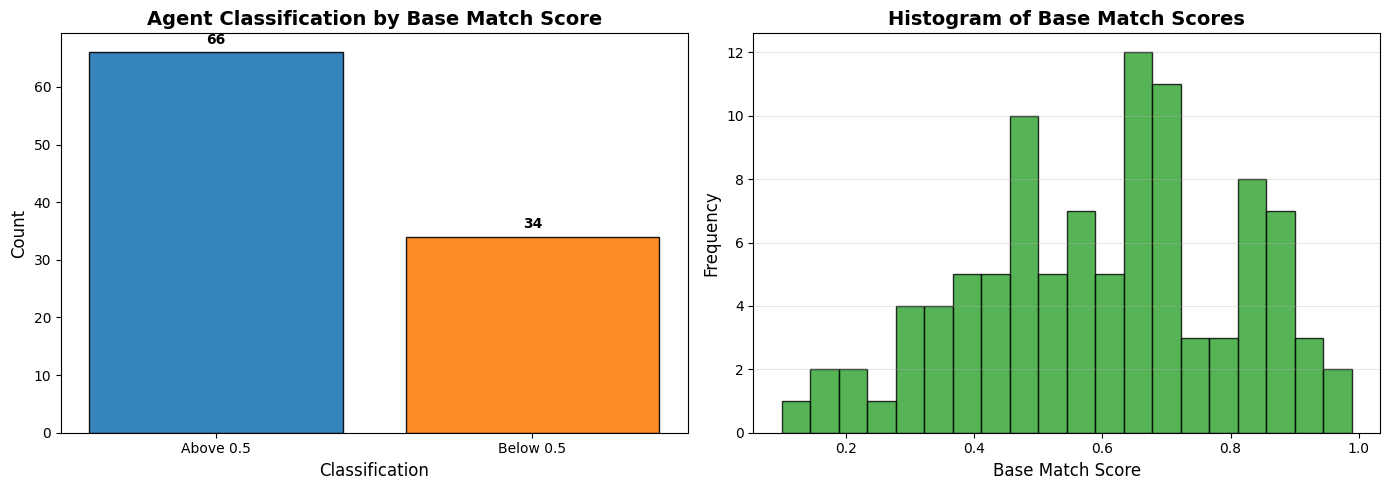

In [5]:
# Classify agents by base_score threshold (0.5)
df_with_scores['base_match_class'] = df_with_scores['base_score'].apply(
    lambda x: 'Above 0.5' if x >= 0.5 else 'Below 0.5'
)

# Count agents in each class (preserve order)
labels = ['Above 0.5', 'Below 0.5']
class_counts_series = df_with_scores['base_match_class'].value_counts()
counts = [int(class_counts_series.get(l, 0)) for l in labels]

# Create side-by-side plots: bar chart + histogram of base_score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Bar chart of classification counts
axes[0].bar(labels, counts, color=['#1f77b4', '#ff7f0e'], edgecolor='black', alpha=0.9)
axes[0].set_title('Agent Classification by Base Match Score', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classification', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(labels, rotation=0)
for i, v in enumerate(counts):
    axes[0].text(i, v + max(1, int(max(counts) * 0.01)), str(v), ha='center', va='bottom', fontweight='bold')

# Right: Histogram of base_score values
base_scores = df_with_scores['base_score'].dropna()
axes[1].hist(base_scores, bins=20, color='#2ca02c', edgecolor='black', alpha=0.8)
axes[1].set_title('Histogram of Base Match Scores', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Base Match Score', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



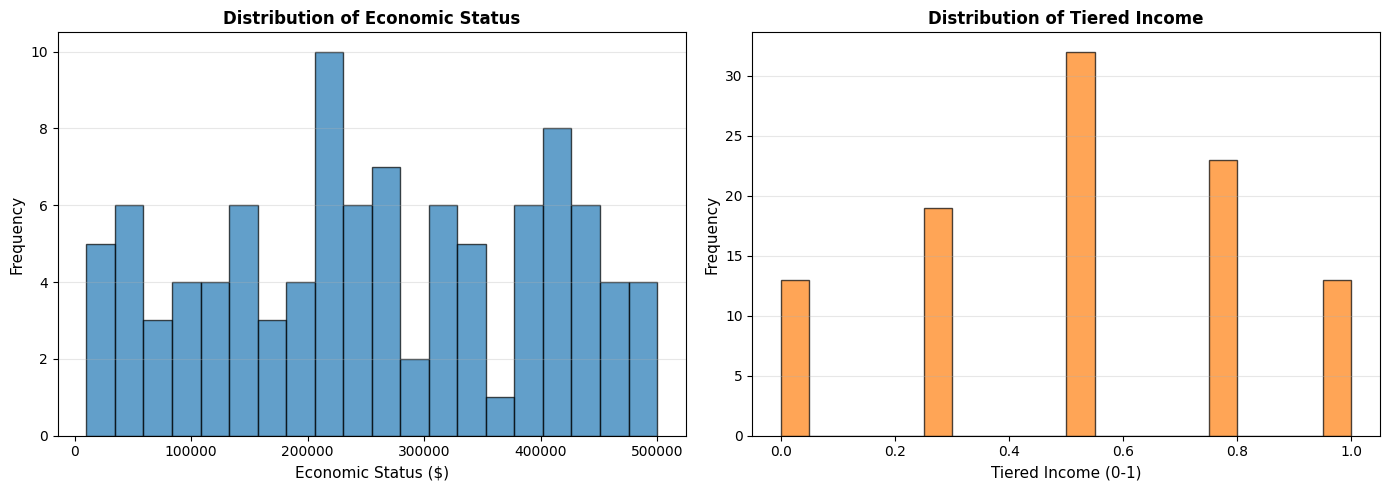

Economic Status Summary:
count       100.000000
mean     258200.000000
std      140292.839475
min       10000.000000
25%      145000.000000
50%      245000.000000
75%      386250.000000
max      500000.000000
Name: economic_status, dtype: float64

Tiered Income Summary:
count    100.000000
mean       0.510000
std        0.303432
min        0.000000
25%        0.250000
50%        0.500000
75%        0.750000
max        1.000000
Name: tiered_income, dtype: float64


In [6]:
# Create two histograms: economic_status and tiered_income distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram 1: Economic Status
axes[0].hist(df_agents['economic_status'], bins=20, color='#1f77b4', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Economic Status', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Economic Status ($)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Histogram 2: Tiered Income
axes[1].hist(df_agents['tiered_income'], bins=20, color='#ff7f0e', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of Tiered Income', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Tiered Income (0-1)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("Economic Status Summary:")
print(df_agents['economic_status'].describe())
print("\nTiered Income Summary:")
print(df_agents['tiered_income'].describe())
